In [54]:
import numpy as np
import json as js
import networkx as nx
import matplotlib.pyplot as plt
from math import radians, cos, sin, asin, sqrt
import time

In [55]:
# AQUITAINE
fileA = open('datas/aquitaine.json')
dataA = js.load(fileA)
elementsAquitaine = dataA["elements"]
fileA.close()

#GIRONDE
fileG = open('datas/gironde.json')
dataG = js.load(fileG)
elementsGironde = dataG["elements"]
fileG.close()

In [56]:
def haversine(point1, point2):
    lat1, lon1, lat2, lon2 = map(radians, [point1[0], point1[1], point2[0], point2[1]])

    # haversine formula 
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371  # Radius of the Earth in kilometers. Use 3956 for miles. Determines return value units.
    return round(c * r,2)

In [57]:
#regroupe les coordonnées en couple
#nodesMap = {id, [lat, lon, stations, marqué]}
def createNodesMap(elements):
    nodesMap = {}
    for e in elements:
        if (e["type"] == "node"):
            if("tags" in e):
                if("name" in e["tags"]):
                    if(e["tags"]["name"].startswith("Aire")):
                        point = [e["lat"],e["lon"],1,0,e["tags"]["name"]]
                    else:
                        point = [e["lat"],e["lon"],0,0,None]
                else:
                    point = [e["lat"],e["lon"],0,0,None]

            else:
                point = [e["lat"],e["lon"],0,0,None]
            # ajout dans le dictionnaire
            nodesMap.update({e["id"] : point})

    return nodesMap

nodesMapAquitaine = createNodesMap(elementsAquitaine)
nodesMapGironde = createNodesMap(elementsGironde)

In [58]:
def initialize_ways(elements, nodesMap):
    motorway_nodes = {}  # Dictionnaire pour les nœuds associés à motorway
    trunk_nodes = {}  # Dictionnaire pour les nœuds associés à trunk
    other_area_nodes = {}  # Dictionnaire pour les nœuds associés à d'autres types d'aires

    way_stations = {}  # [node_id, way_id]

    for e in elements:
        same = False
        if e["type"] == "way" and "tags" in e and "name" in e["tags"] and e["tags"]["name"].startswith("Aire"):
            for node in nodesMap.items():
                if node[1][2] == 1:
                    if node[1][4] == e["tags"]["name"]:
                        same = True

            if same == False:
                way_stations.update({e["nodes"][1]: e["id"]})

        elif e["type"] == "way" and "highway" in e["tags"]:
            if e["tags"]["highway"] == "motorway":
                motorway_nodes[e["id"]] = e
            elif e["tags"]["highway"] == "trunk":
                trunk_nodes[e["id"]] = e

    for node in way_stations.items():
        nodesMap.update({node[0]: [nodesMap[node[0]][0], nodesMap[node[0]][1], 1, 0]})
        other_area_nodes.update({node[0]: [nodesMap[node[0]][0], nodesMap[node[0]][1], 1, 0]})

    return motorway_nodes, trunk_nodes, other_area_nodes,way_stations,nodesMap

motorway_nodesA, trunk_nodesA, other_area_nodesA,way_stationsA,nodesMapAquitaine = initialize_ways(elementsAquitaine, nodesMapAquitaine)
motorway_nodesG, trunk_nodesG, other_area_nodesG,way_stationsG,nodesMapGironde = initialize_ways(elementsGironde, nodesMapGironde)


In [59]:
def insertOtherStationsInWay(motorway_nodes, trunk_nodes, other_area_nodes, nodesMap, way_stations, elements,data,output_file):
    for node_id, node_data in other_area_nodes.items():
        
        if node_data[2] == 1:  # Si c'est un noeud aire
            min_distance_motorway = float("inf") # on initialise la distance à l'infini
            closest_motorway = None # on initialise la motorway la plus proche à None

            # de même pour les trunks
            min_distance_trunk = float("inf")
            closest_trunk = None

            # pour chaque motorway, on cherche le noeud le plus proche
            for motorway_id, motorway_data in motorway_nodes.items():

                way_nodes = motorway_data["nodes"] # la liste des nœuds de la way associée à motorway

                first_node = nodesMap.get(way_nodes[0]) # on récupère le premier nœud dans la way

                if first_node:
                    distance = haversine([node_data[0], node_data[1]], [first_node[0], first_node[1]]) # on calcule la distance entre le noeud aire et le premier noeud de la way
                    
                    if distance < min_distance_motorway: # si la distance est inférieure à la distance minimale
                        min_distance_motorway = distance
                        closest_motorway = motorway_data

            # de même pour les trunks	
            for trunk_id, trunk_data in trunk_nodes.items():

                way_nodes = trunk_data["nodes"]

                first_node = nodesMap.get(way_nodes[0])

                if first_node:
                    distance = haversine([node_data[0], node_data[1]], [first_node[0], first_node[1]])
                    if distance < min_distance_trunk:
                        min_distance_trunk = distance
                        closest_trunk = trunk_data

            # On regarde si la motorway ou le trunk le plus proche est à côté du point
            if min_distance_motorway < 2 or min_distance_trunk < 2:

                aire_way_id = way_stations.get(node_id) # on récupère l'id de la way associée à l'aire

                
                if aire_way_id:
                    for element in elements:
                        if element["type"] == "way" and element["id"] == aire_way_id: # on cherche la way associée à l'aire
                            for i in element["nodes"]:
                                if i == node_id: # On supprime le noeud dans son aire
                                    element["nodes"].remove(i)

                # On ajoute le noeud à la motorway ou au trunk le plus proche
                for element in elements:
                    if element["type"] == "way" and element["id"] == closest_motorway["id"]:
                        if node_id not in element["nodes"]:
                            element["nodes"].append(node_id)

    # On ecrit le resultat dans le fichier aquitaineWithOthersStation.json
    with open(output_file, "w") as f:
        js.dump(data, f, indent=4)

#TODO: 2 fichiers de sortie différents en fonction de la région ou du département
insertOtherStationsInWay(motorway_nodesA, trunk_nodesA, other_area_nodesA, nodesMapAquitaine, way_stationsA, elementsAquitaine,dataA, "datas/aquitaineWithOthersStation.json")
insertOtherStationsInWay(motorway_nodesG, trunk_nodesG, other_area_nodesG, nodesMapGironde, way_stationsG, elementsGironde,dataG, "datas/girondeWithOthersStation.json")

In [60]:
# AQUITAINE
fileA = open('datas/aquitaineWithOthersStation.json')
dataA = js.load(fileA)
elementsAquitaine = dataA["elements"]
fileA.close()

# GIRONDE
fileG = open('datas/girondeWithOthersStation.json')
dataG = js.load(fileG)
elementsGironde = dataG["elements"]
fileG.close()

In [61]:
# noSimpleGraph : {idNode : {
#        nextNodes : [node1,node2,...],
#        prevNodes : [node1,node2,...]
#}}
# 
def updateGraph(graph,idNode,nextNode,prevNode):

    if nextNode != None:
        graph[idNode]["nextNodes"].append(nextNode)
    if prevNode != None:
        graph[idNode]["prevNodes"].append(prevNode)

def createNoSimpleGraphFromElements(elements):
    start_nodes = set()  # Créez un ensemble pour stocker les nœuds de départ

    for e in elements:
        if e["type"] == "way":
            start_node = e["nodes"][0]  # Le premier nœud du chemin est le nœud de départ
            start_nodes.add(start_node)

    noSimpleGraph = {}

            
    for nodes in elements:
        if (nodes["type"] == "way"):
            for i in range(len(nodes["nodes"])):
                idNode = nodes["nodes"][i] 

                if idNode not in noSimpleGraph:
                    noSimpleGraph.update({idNode : {"nextNodes" :[],
                                        "prevNodes" : []}})

                if i == 0:
                    updateGraph(noSimpleGraph,idNode,nodes["nodes"][i+1],None)

                elif i == (len(nodes["nodes"])-1):
                    updateGraph(noSimpleGraph,idNode,None,nodes["nodes"][i-1])
                else:
                    updateGraph(noSimpleGraph,idNode,nodes["nodes"][i+1],nodes["nodes"][i-1])
    return noSimpleGraph
noSimpleGraphAquitaine = createNoSimpleGraphFromElements(elementsAquitaine)
noSimpleGraphGironde = createNoSimpleGraphFromElements(elementsGironde)



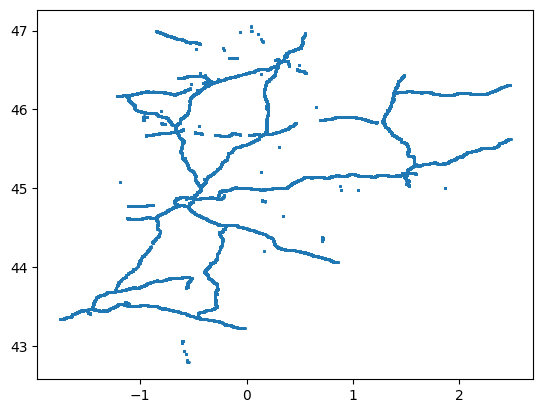

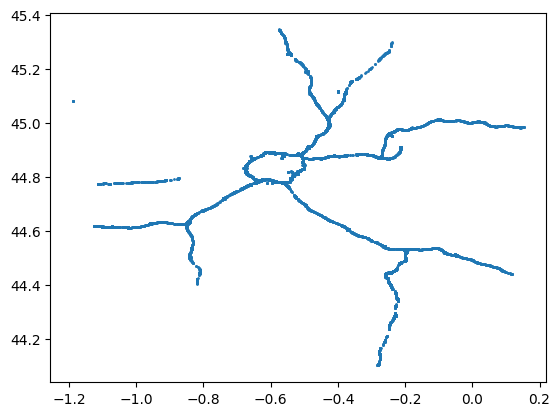

In [62]:
def display_noSimpleGraph(noSimpleGraph,nodesMap):
        xpoints = []
        ypoints = []
        for node in noSimpleGraph.items():
                xpoints.append(nodesMap[node[0]][0])
                ypoints.append(nodesMap[node[0]][1])

        latitude = np.array(xpoints)
        longitude = np.array(ypoints)

        plt.scatter(longitude,latitude,s=1)
        plt.show()

display_noSimpleGraph(noSimpleGraphAquitaine,nodesMapAquitaine)
display_noSimpleGraph(noSimpleGraphGironde,nodesMapGironde)

In [63]:
def updateSimpleGraph(graph,idNode):
    if idNode not in graph:
        graph.update({idNode : {"nextNodes" :[],
                                       "prevNodes" : []}})
    return graph

In [64]:
# fonction pour trouver les prochains nœuds de la station
def nextStation(graph, startNode, nodesMap,newGraph):

    visitedNodes = set()
    stack = [(startNode, None, 0)]

    while stack:
        node, lastStationNode, lastDistance = stack.pop()

        if node not in visitedNodes:
            visitedNodes.add(node)
            if nodesMap[node][2] == 1:
                updateSimpleGraph(newGraph, node)
                if lastStationNode is not None:
                    newGraph[lastStationNode]["nextNodes"].append([node, lastDistance])
                    newGraph[node]["prevNodes"].append([lastStationNode, lastDistance])
                lastStationNode = node
                lastDistance = 0.0

            for nextNode in graph.get(node, {}).get("nextNodes", []):
                if nextNode not in visitedNodes:
                    distance = haversine([nodesMap[node][0], nodesMap[node][1]], [nodesMap[nextNode][0], nodesMap[nextNode][1]])
                    distance = round(distance, 2)
                    stack.append((nextNode, lastStationNode, round(lastDistance + distance, 2)))

    return newGraph

def createSimpleGraph(graph, nodesMap):
    newGraph = {}
    counter = 0
    for node_id, node_data in nodesMap.items():
        if node_data[2] == 1:
            nextStation(graph, node_id, nodesMap,newGraph)
            counter += 1
    print("nombre de noeuds dans le graphe simple : ",len(newGraph))
    return newGraph

simpleGraphAquitaine = createSimpleGraph(noSimpleGraphAquitaine, nodesMapAquitaine)
simpleGraphGironde = createSimpleGraph(noSimpleGraphGironde, nodesMapGironde)

nombre de noeuds dans le graphe simple :  152
nombre de noeuds dans le graphe simple :  39


In [65]:
# fonction pour supprimer les noeuds sans voisins
def deleteUselessNodes(graph):
    uselessNodes = []
    for node_id, node_data in graph.items():
        if len(node_data["nextNodes"]) == 0 and len(node_data["prevNodes"]) == 0:
            uselessNodes.append(node_id)
    for node in uselessNodes:
        del graph[node]
    return graph

# fonction pour supprimer avec plusieurs fois le meme voisin
def deleteMultipleNeighbours(graph):
    for node_id, node_data in graph.items():
        node_data["nextNodes"] = [list(x) for x in dict.fromkeys(tuple(x) for x in node_data["nextNodes"])]
        node_data["prevNodes"] = [list(x) for x in dict.fromkeys(tuple(x) for x in node_data["prevNodes"])]
    return graph

simpleGraphAquitaine = deleteUselessNodes(simpleGraphAquitaine)
simpleGraphGironde = deleteUselessNodes(simpleGraphGironde)

simpleGraphAquitaine = deleteMultipleNeighbours(simpleGraphAquitaine)
simpleGraphGironde = deleteMultipleNeighbours(simpleGraphGironde)

print(simpleGraphAquitaine)

{21462004: {'nextNodes': [[4773153946, 10.93]], 'prevNodes': [[5752418984, 13.91]]}, 4773153946: {'nextNodes': [[889487302, 12.76]], 'prevNodes': [[21462004, 10.93]]}, 889487302: {'nextNodes': [[889499418, 13.67]], 'prevNodes': [[4773153946, 12.76]]}, 889499418: {'nextNodes': [[889499563, 9.26], [524116661, 52.93], [4158212734, 26.53], [6188082759, 41.48], [665145798, 57.0], [4330739874, 46.65], [606119131, 106.13]], 'prevNodes': [[889487302, 13.67]]}, 889499563: {'nextNodes': [[889487349, 14.23]], 'prevNodes': [[889499418, 9.26], [883463680, 54.95], [606119155, 103.41]]}, 889487349: {'nextNodes': [[85736812, 34.3], [9692813053, 16.93]], 'prevNodes': [[889499563, 14.23]]}, 85736812: {'nextNodes': [[889526539, 9.74]], 'prevNodes': [[889487349, 34.3], [7236488225, 27.92]]}, 889526539: {'nextNodes': [[1876578765, 14.06]], 'prevNodes': [[85736812, 9.74]]}, 1876578765: {'nextNodes': [[1876578796, 10.53]], 'prevNodes': [[889526539, 14.06]]}, 1876578796: {'nextNodes': [[882253871, 16.94], [88

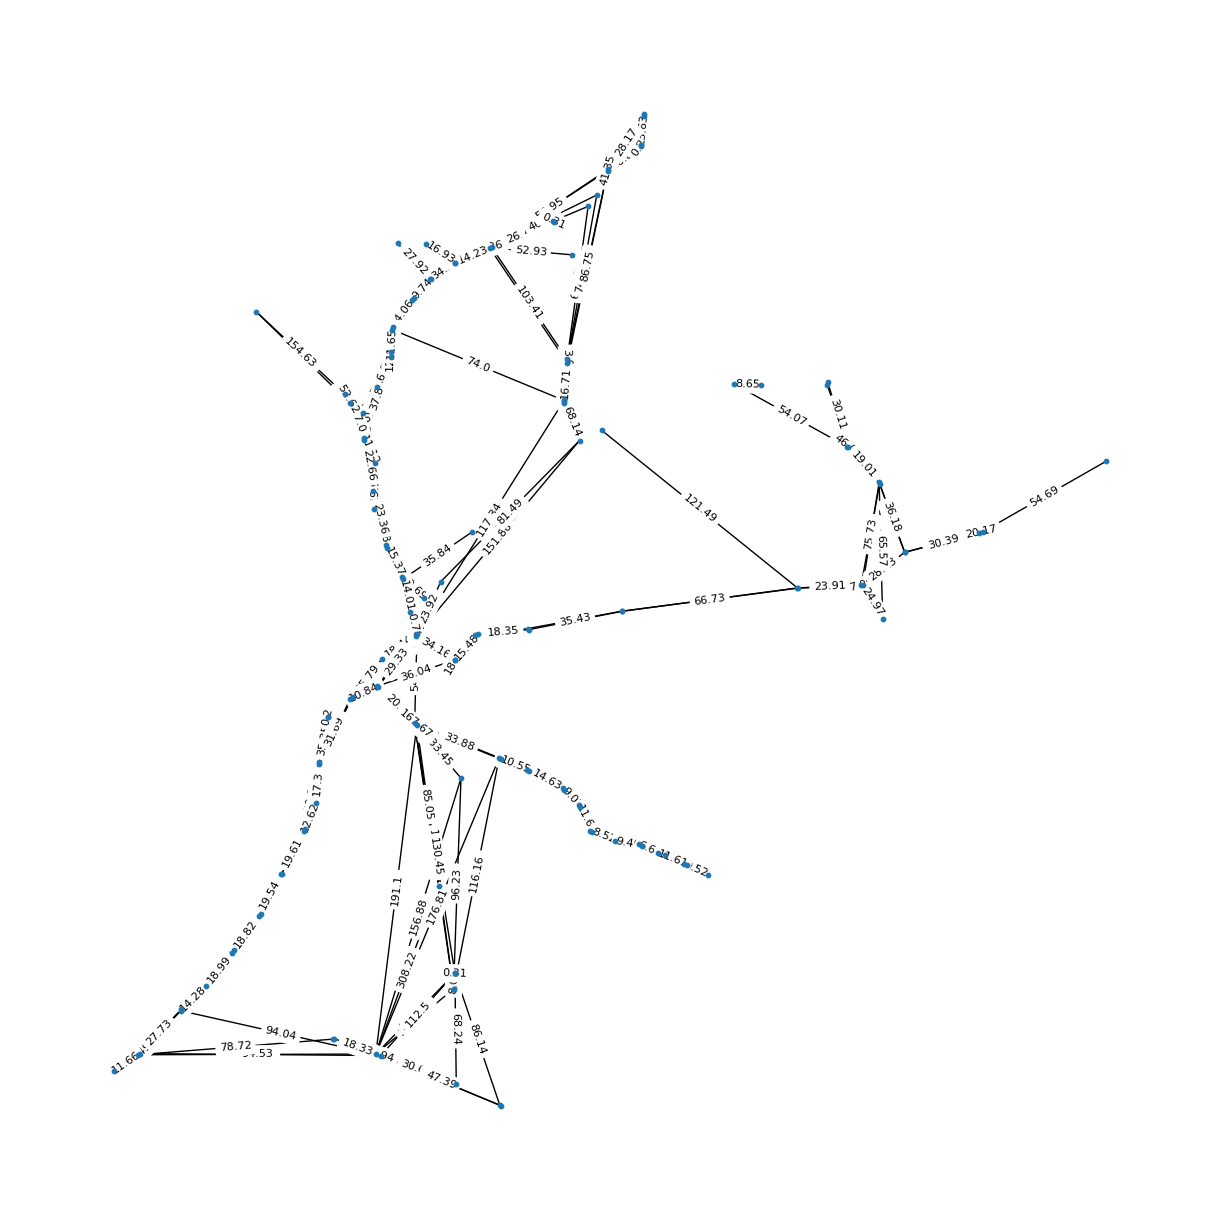

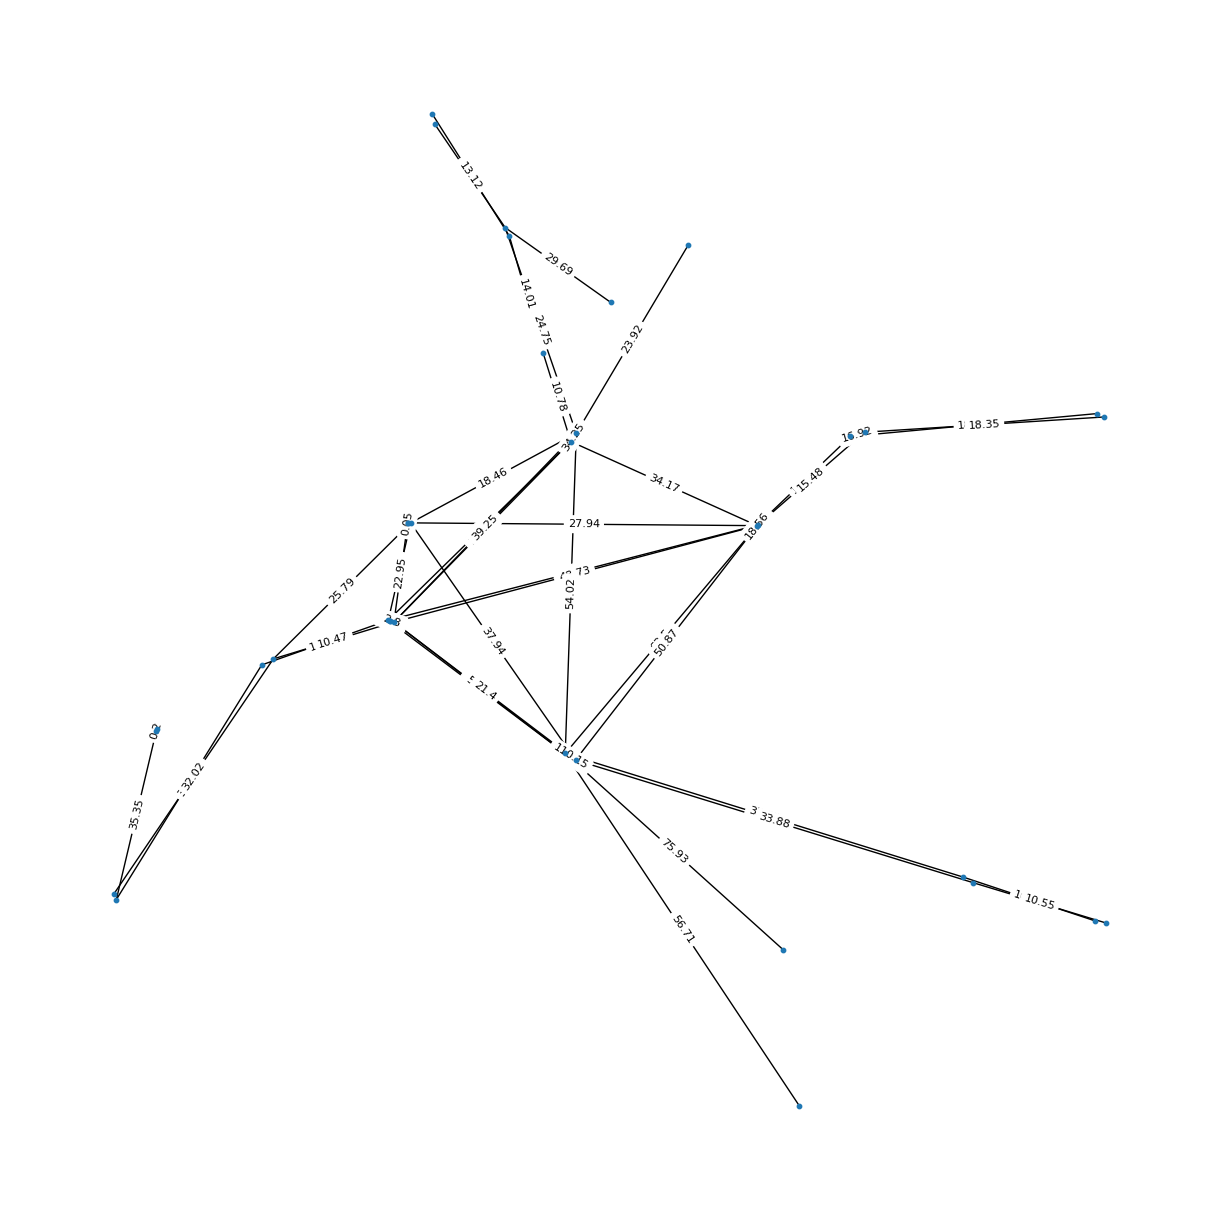

In [66]:
def display_simpleGraph(graph,nodesMap):
    G = nx.Graph()

    for node, data in graph.items():
        G.add_node(node, latitude=nodesMap[node][0], longitude=nodesMap[node][1])

    for node, data in graph.items():
        for next_node, distance in data.get("nextNodes", []):
            G.add_edge(node, next_node, distance=distance)

    node_positions = {node: (nodesMap[node][1], nodesMap[node][0]) for node in G.nodes()}

    edge_distances = {(u, v): d['distance'] for u, v, d in G.edges(data=True)}

    plt.figure(figsize=(12, 12))
    nx.draw(G, pos=node_positions, with_labels=False, node_size=10)
    nx.draw_networkx_edge_labels(G, pos=node_positions, edge_labels=edge_distances, font_size=8)
    plt.show()

# Appliquer la fonction display_simpleGraph() à newGraphs
display_simpleGraph(simpleGraphAquitaine, nodesMapAquitaine)
display_simpleGraph(simpleGraphGironde, nodesMapGironde)

In [67]:
def floydWarshall(graph):
    matrix = {node: {} for node in graph}


    for aire in graph:
        if graph[aire]["prevNodes"]:
            neighbour1, distance1 = graph[aire]["prevNodes"][0]
            matrix[aire][neighbour1] = distance1
        if graph[aire]["nextNodes"]:
            neighbour2, distance2 = graph[aire]["nextNodes"][0]
            matrix[aire][neighbour2] = distance2

    for k in graph:
        for i in graph:
            for j in graph:
                if i != j:
                    new_distance = matrix[i].get(j, float('inf'))
                    matrix[i][j] = min(new_distance, matrix[i].get(k, float('inf')) + matrix[k].get(j, float('inf')))

    return matrix

resultAquitaine = floydWarshall(simpleGraphAquitaine)
resultGironde = floydWarshall(simpleGraphGironde)


In [68]:
print(simpleGraphGironde[249778863]['nextNodes'])

[[313750636, 15.48]]


In [69]:
print(simpleGraphGironde)
print(simpleGraphAquitaine[4357310089])

{21462872: {'nextNodes': [[1893894292, 10.78]], 'prevNodes': [[245469652, 29.34], [245469945, 39.54], [313750636, 34.17], [726554853, 34.25]]}, 1893894292: {'nextNodes': [[5761204260, 14.01]], 'prevNodes': [[21462872, 10.78]]}, 5761204260: {'nextNodes': [[2587088569, 15.37]], 'prevNodes': [[1893894292, 14.01]]}, 2587088569: {'nextNodes': [], 'prevNodes': [[5761204260, 15.37]]}, 21463090: {'nextNodes': [[245469652, 10.84]], 'prevNodes': [[101439017, 31.69]]}, 245469652: {'nextNodes': [[1452352758, 4.53], [21462872, 29.34], [245469945, 43.9], [318151675, 58.67], [244598847, 23.11], [315104887, 36.04]], 'prevNodes': [[21463090, 10.84], [244598847, 21.02]]}, 1452352758: {'nextNodes': [], 'prevNodes': [[245469652, 4.53]]}, 245469945: {'nextNodes': [[513717312, 10.47], [2385523967, 22.95], [1452352726, 2.8], [21462872, 39.54], [318151675, 59.31]], 'prevNodes': [[245469652, 43.9], [313750636, 48.73], [726554853, 39.25], [318182389, 21.4]]}, 513717312: {'nextNodes': [[736942879, 32.02]], 'prev

In [70]:
def stationsOnWay(graph, start, end, path=[]):
    # Add the current node to the path
    path = path + [start]

    # Check if the current node is the destination
    if start == end:
        return path

    # Check if the current node exists in the graph
    if start not in graph:
        return []

    # Explore neighbors using Depth-First Search (DFS)
    for node, _ in graph[start]['nextNodes']:
        # Check if the neighbor is not already visited
        if node not in path:
            # Recursively find the path from the neighbor to the destination
            new_path = stationsOnWay(graph, node, end, path)
            if new_path:
                return new_path

    # If no path is found
    return []

def retrieveStationsOnWay(graph, start, end):
    # Find the forward path from start to end nodes
    forward_path = stationsOnWay(graph, start, end)
    if forward_path:
        return forward_path
    else:
        # Find the backward path from end to start nodes
        backward_path = stationsOnWay(graph, end, start)
        return backward_path    
    

# Example
start_node = 21463090
end_node = 5761204260

# Retrieve and print the path nodes
path_nodes = retrieveStationsOnWay(simpleGraphGironde, start_node, end_node)
print(path_nodes)


[21463090, 245469652, 21462872, 1893894292, 5761204260]


In [71]:
s = {}
fW = {}



#Créer le graphe G' à partir du resultat de floydWarshall. Ce nouveau graphe sera utilisé par les algo EnsembleDominant
def transformGraph(dist, simpleGraph, resultFW):
    pcc = -1
    for sommet in resultFW :
        #print(sommet)
        s.update({sommet : []})
        for voisin in resultFW[sommet]:
            if resultFW[sommet][voisin]> dist and resultFW[sommet][voisin]!= float('inf') :
                fW.update({pcc : retrieveStationsOnWay(simpleGraph,sommet,voisin)}) #chaque noeuds "pcc" (plus court chemin) possèdent une liste des stations parcourus
                if(pcc == -403):
                    print(sommet, voisin)
                    print(fW[pcc])
                    print(resultFW[sommet][voisin])
                pcc -= 1
    for fWNode in fW :
        for sNode in fW[fWNode]:
            s[sNode].append(fWNode)
                

transformGraph(60,simpleGraphAquitaine,resultAquitaine)
print(s)
#print(fW)


# On doit créer un graphe G’ Union de 2 ensemble :
# Le premier ensemble S : l’ensemble des sommets (air) de notre premier graphe 
# Le deuxième FW, l’ensemble des plus courts chemin de plus de k (car seuls les chemins de plus de k doivent être traités) (60km par défaut) généré par floyd-Warshall 
# Ces plus courts chemin deviennent des sommets 
# Pour créer le graphe il faut des arrêtes : les liens se font entre les sommets de S et de FW : pour les trouver, il faut lister la liste des stations dans chaque plus court chemin.
# On se retrouve avec pour chaque sommet de FW au moins 2 arrête vers 2 sommets de S.

# VOIR prochaine cellule



4357310089 1049755706
[]
348.13
{21462004: [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -112, -134, -135, -136, -156, -157, -158, -159, -178, -179, -180, -181, -182, -200, -201, -202, -203, -204, -205, -222, -223, -224, -225, -226, -227, -243, -244, -245, -246, -247, -248, -249, -264, -265, -266, -267, -268, -269, -270, -271, -286, -287, -288, -289, -290, -291, -292, -293, -294, -308, -309, -310, -311, -312, -313, -314, -315, -316, -317, -330, -331, -332, -333, -334, -335, -336, -337, -338, -339, -340, -353, -354, -355, -356, -357, -358, -359, -360, -361, -362, -363, -364, -378, -401, -402, -404, -405, -406, -407, -408, -409, -410, -411, -412, -413, -414, -415, -426, -427, -428, -429, -430, -431, -432, -433, -434, -435, -436, -437, -450, -451, -452, -453, -474, -475, -476, -477, -498, -499, -500, -501, -522, -523, -524, -525, -546, -547, -548, -549, -572, -573, -574, -575, -576, -577, -578, -579, -580, -581, -582, -583, -598

In [72]:
# De plus il faut que chaque sommet de S soit relié à tous les sommets de S pour créer une Clique sur tout l'ensemble S 
# Une fois que le graphe est créé il faut appliqué le brut force ED sur ce nouveau graphe avec la contrainte que seul les Sommets de S peuvent être dominant

def addClique(s):
    cpt = 0
    for node in s :
        cpt += 1
        for cliqueNeighbor in s:
            if cliqueNeighbor == node :
                continue
            else :
                s[node].append(cliqueNeighbor)

addClique(s)
#print(s)
#print(cpt)


graphTransformed = s
print(graphTransformed)

{21462004: [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -112, -134, -135, -136, -156, -157, -158, -159, -178, -179, -180, -181, -182, -200, -201, -202, -203, -204, -205, -222, -223, -224, -225, -226, -227, -243, -244, -245, -246, -247, -248, -249, -264, -265, -266, -267, -268, -269, -270, -271, -286, -287, -288, -289, -290, -291, -292, -293, -294, -308, -309, -310, -311, -312, -313, -314, -315, -316, -317, -330, -331, -332, -333, -334, -335, -336, -337, -338, -339, -340, -353, -354, -355, -356, -357, -358, -359, -360, -361, -362, -363, -364, -378, -401, -402, -404, -405, -406, -407, -408, -409, -410, -411, -412, -413, -414, -415, -426, -427, -428, -429, -430, -431, -432, -433, -434, -435, -436, -437, -450, -451, -452, -453, -474, -475, -476, -477, -498, -499, -500, -501, -522, -523, -524, -525, -546, -547, -548, -549, -572, -573, -574, -575, -576, -577, -578, -579, -580, -581, -582, -583, -598, -599, -600, -601, -602, -603, 

In [73]:
print(len(resultAquitaine))

135


In [74]:
def verifED(graph, ed):
    for node in graph:
        if node not in ed:
            dominated = False
            for neighbour in graph[node]:
                if neighbour in ed:
                    dominated = True
                    break
            #for dominator in ed:

                #if dominator in graph[node]["nextNodes"] or dominator in graph[node]["prevNodes"]:
                    #dominated = True
                #if dominated:
                    #break
            if not dominated:
                return False
    return True

def verifEDgprime(FW, ed):
    for node in FW:
        if(len(FW[node]) == 1):
            print(FW[node])
        dominated = False
        for dominator in ed:
            if dominator in FW[node]:
                dominated = True
                break
        if not dominated:
            return False
    return True


def bruteforce(graph, fW):
    ed = []
    for node in graph:
        ed.append(node)
    validEDs = []
    validEDs.append(ed.copy())
    for i in range(1, len(graph) + 1):
        newValidEDs = []
        for validED in validEDs:
            result = recursive(graph, 1, validED, fW)
            if result[0]:
                newValidEDs.append(result[1])
        if len(newValidEDs) == 0:
            if i == 1:
                #print("Pas de solution trouvée")
                return []
            else:
                #print("Une solution de taille " + str(len(validEDs[0])) + " a été trouvée.")
                #print("Des stations de recharge sont situées sur les aires :")
                #for i in validEDs[0]:
                    #print(i, end=" ")
                #print()
                return validEDs[0]
        else:
            print()
            validEDs = newValidEDs
    #print("Une solution de taille " + str(len(validEDs[0])) + " a été trouvée.")
    #print("Des stations de recharge sont situées sur les aires :")
    for i in validEDs[0]:
        print(i, end=" ")
    print()
    return validEDs[0]

def recursive(graph, elementsLeft, ed, fW):
    validEDs = []
    if elementsLeft > 0:
        for node in graph:
            if node in ed and not graph[node] == []:
                newED = ed.copy()
                newED.remove(node)
                result = recursive(graph, elementsLeft-1, newED, fW)
                if result[0]:
                    validEDs.append(result[1])
        if len(validEDs) > 0:
            return True, validEDs
        else:
            return False, ed 
    else:
        if verifEDgprime(fW, ed):
            #print("Une solution de taille " + str(len(ed)) + " a été trouvée.")
            #print("Des stations de recharge sont situées sur les aires :")
            #for i in ed:
                #print(i, end=" ")
            #print()
            return True, ed
        else:
            return False, ed

testGraph = {
    '5': {'nextNodes': [['3'], ['7']], 'prevNodes': []},
    '3': {'nextNodes': [['2'], ['4'], ['5']], 'prevNodes': []},
    '7': {'nextNodes': [['8'], ['5']], 'prevNodes': []},
    '2': {'nextNodes': [['3']], 'prevNodes': []},
    '4': {'nextNodes': [['3']], 'prevNodes': []},
    '8': {'nextNodes': [['4'], ['7']], 'prevNodes': []}
}


s = {}
fW = {}
#badGraph = []
#goodGraph = []
transformGraph(60,simpleGraphAquitaine, resultAquitaine)
addClique(s)
#graphPrimeGironde = transformGraph(60, simpleGraphGironde, resultGironde)
badGraph = ['4', '7']
goodGraph = ['3', '7']
#print(verifED(graphPrime, ed))
minimalEDAquitaine = bruteforce(s, fW)
print(minimalEDAquitaine)
#minimalEDGironde = bruteforce(graphPrimeGironde)

4357310089 1049755706
[]
348.13
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
-403
[]


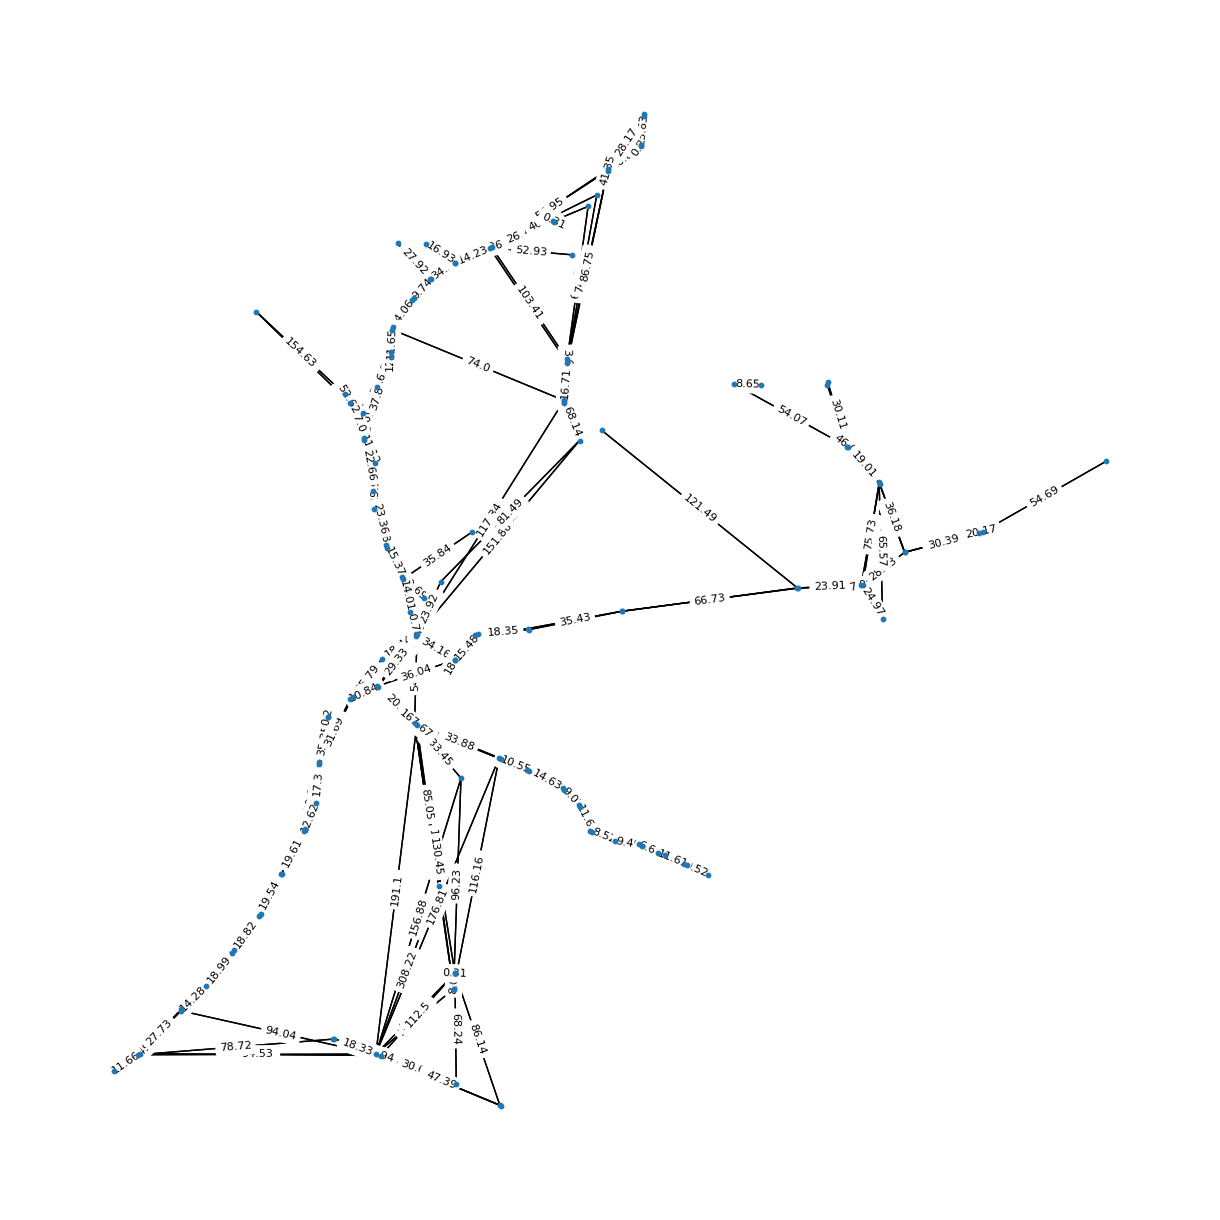

In [75]:
def display_ED_brutforce(simpleGraph, nodesMap, minimalED):
    G = nx.Graph()

    for node, data in simpleGraph.items():
        G.add_node(node, latitude=nodesMap[node][0], longitude=nodesMap[node][1])




    for node, data in simpleGraph.items():
        for next_node, distance in data.get("nextNodes", []):
            G.add_edge(node, next_node, distance=distance)

    node_positions = {node: (data['longitude'], data['latitude']) for node, data in G.nodes(data=True)}

    edge_distances = nx.get_edge_attributes(G, 'distance')

    plt.figure(figsize=(12, 12))
    nx.draw(G, pos=node_positions, with_labels=False, node_size=10)
    nx.draw(G, pos=node_positions, nodelist=minimalED, with_labels=False, node_color="tab:red", node_size=20)
    nx.draw_networkx_edge_labels(G, pos=node_positions, edge_labels=edge_distances, font_size=8)
    plt.show()

display_ED_brutforce(simpleGraphAquitaine, nodesMapAquitaine, minimalEDAquitaine)
#display_ED_brutforce(simpleGraphGironde, nodesMapGironde, minimalEDGironde)

In [76]:
def calculPerformance():
    # createNoSimpleGraphFromElements
    tic = time.perf_counter()
    createNoSimpleGraphFromElements(elements)
    toc = time.perf_counter()

    timeNoSimpleGraph = toc - tic

    # createSimpleGraph
    tic = time.perf_counter()
    createSimpleGraph(noSimpleGraph, nodesMap)
    toc = time.perf_counter()

    timeSimpleGraph = toc - tic
    # stationsOnWay
    tic = time.perf_counter()
    stationsOnWay(graph, way, stations)
    toc = time.perf_counter()

    timeStationsOnWay = toc - tic
    # floydWarshall
    # bruteForce

    # x=[timeNoSimpleGraph,timeSimpleGraph,timeStationsOnWay]

    # print("Temps pour créer le graphe non simple : ",timeNoSimpleGraph)
    # print("Temps pour créer le graphe simple : ",timeSimpleGraph)
    # plt.hist(x, 50,facecolor='b', alpha=0.5)

    # plt.xlabel('Functions')
    # plt.ylabel('Time')
    # plt.title('Performance')
    # plt.axis([0, 6, 0, 40])
    # plt.grid(True)
    # plt.show()
    
calculPerformance()

NameError: name 'elements' is not defined